In [1]:
import medmnist
from medmnist import INFO, Evaluator

import torch
import torch.nn as nn 
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

from tqdm import tqdm
import numpy as np

/Users/carlosgil/.pyenv/versions/3.10.3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_flag = "dermamnist"
# data_flag = "bloodmnist"
# data_flag = "organamnist"
# data_flag = "organcmnist"
# data_flag = "organsmnist"
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
num_channels = info['n_channels']
num_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

print(info)
print(DataClass)

{'python_class': 'DermaMNIST', 'description': 'The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.', 'url': 'https://zenodo.org/record/6496656/files/dermamnist.npz?download=1', 'MD5': '0744692d530f8e62ec473284d019b0c7', 'task': 'multi-class', 'label': {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}, 'n_channels': 3, 'n_samples': {'train': 7007, 'val': 1003, 'test': 2005}, 'license': 'CC BY 4.0'}
<class 'medmnist.dataset.DermaMNIST'>


In [3]:
#preprocessing
data_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[.5], std=[.5]) #output[channel] = (input[channel] - mean[channel]) / std[channel]
])

#loading
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

#encapsulating
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# print(train_dataset)
# print("===============")
# print(test_dataset)

Using downloaded and verified file: /Users/carlosgil/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/carlosgil/.medmnist/dermamnist.npz


/Users/carlosgil/.pyenv/versions/3.10.3/lib/python3.10/site-packages/medmnist/utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


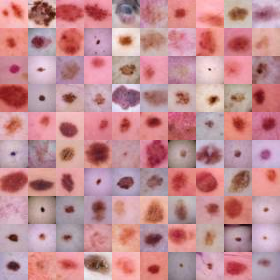

In [4]:
#visualization
train_dataset.montage(length=10)

In [5]:
#Define CNN model

class Net(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(Net, self).__init__()

    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels, 16, kernel_size=3),
      nn.BatchNorm2d(16),
      nn.ReLU() #activation function
    )

    self.layer2 = nn.Sequential(
      nn.Conv2d(16, 16, kernel_size=3),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.layer3 = nn.Sequential(
      nn.Conv2d(16, 64, kernel_size=3),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )

    self.layer4 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=3),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )

    self.layer5 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fc = nn.Sequential(
      nn.Linear(64 * 4 * 4, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, num_classes)
    )

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

model = Net(in_channels=num_channels, num_classes=num_classes)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [6]:
#model
for _ in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 55/55 [00:04<00:00, 13.04it/s]


In [24]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
    
    #len(y_true) == len(y_score)
    print(len(y_true))
    print(len(y_score))
        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.818  acc:0.670
7007
7007
test  auc: 0.813  acc:0.669
2005
2005
